# Project - Cdiscount Image Classification



# Data ingestion
The primary training set is a 57GB bson file, having ~15 Million images (180x180 images in Base64 format) of ~7.06 Million products. We have imported the dataset into a MongoDB instance on a VPS, so we were able to query among the records.
We have chosen 100 categories, which overally consist of ~246K images of ~110K products.


## Dataset preparation

First we need to ensure that the "gdown" library is installed and accessible in the environment and download the train_medium data from Google Drive,

In [1]:
! pip install gdown && gdown --id 1F6Xf4yiYxeFEN6qhrL3YBNs0Vhx0bXJ1

Downloading...
From: https://drive.google.com/uc?id=1F6Xf4yiYxeFEN6qhrL3YBNs0Vhx0bXJ1
To: /content/train_shuffled_100cat.csv
1.62GB [00:07, 208MB/s]


## Note for the team
Since the original dataset is pretty large, I've created a subset file containing ~250K photos in 100 categories, but it is still so large that it may not fit into the memory, so I've used the below parameters to load a fitable subset accordingly, please read the comments of each variable careflully, and do not change the loading code please, just the values of the parameters.

In [3]:
CONVERT_TO_NP_ARRAY= True   # Wether convert the Base64 string to (180,180,3) arrays or keep the string. 

LOADING_MODE = "num_categories" 
                             # num_records: Loads the first NUM_RECORDS in the dataset and calculates NUM_CATEGORIES dynamically
                             # num_categories: Loads first NUM_CATEGORIES and calculates NUM_RECORDS dynamically
                             # all: Loads all the 250K images, ignores all parameters below
                            
    
NUM_RECORDS = 3000           # Only used when the mode is set to num_records
NUM_CATEGORIES = 10           # Only used when the mode is set to num_category
MAX_RECORDS_PER_CATEGORY =250 # if not zero, will ensure that there is no more per category in the dataframe, won't work when mode is set to all

In [4]:
import pandas as pd

import base64
from PIL import Image
import base64
import io
import numpy as np
import tensorflow as tf


FILE_NAME= "train_shuffled_100cat.csv"
header = 3

df = pd.read_csv(FILE_NAME, header=3, nrows=0)

if LOADING_MODE == "all":
    df = pd.read_csv(FILE_NAME, header=header)

if LOADING_MODE == "num_records":
    reader = pd.read_csv(FILE_NAME, header=header, chunksize=min(NUM_RECORDS, 100))
    for chunk in reader:
        df = df.append(chunk, ignore_index=True)
        if MAX_RECORDS_PER_CATEGORY:
            for cat in df["category_id"].unique():
                if len(df[df["category_id"] == cat]) > MAX_RECORDS_PER_CATEGORY:
                    removed_rows = df[df["category_id"] == cat][MAX_RECORDS_PER_CATEGORY:]
                    df = df.drop(removed_rows.index)
        if df.shape[0]>=NUM_RECORDS:
            df = df.head(NUM_RECORDS)
            break
    
elif LOADING_MODE == "num_categories": 
    reader = pd.read_csv(FILE_NAME, header=header, chunksize=100)
    for chunk in reader:
        df = df.append(chunk, ignore_index=True)
        if df["category_id"].nunique() > NUM_CATEGORIES:
            break
    if MAX_RECORDS_PER_CATEGORY:
        for cat in df["category_id"].unique():
            if len(df[df["category_id"] == cat]) > MAX_RECORDS_PER_CATEGORY:
                removed_rows = df[df["category_id"] == cat][MAX_RECORDS_PER_CATEGORY:]
                df = df.drop(removed_rows.index)

    cat_removed = df["category_id"].unique()[NUM_CATEGORIES:]
    df = df.loc[~df['category_id'].isin(cat_removed)]
    NUM_RECORDS= df.shape[0]

if CONVERT_TO_NP_ARRAY:        
    df["image"] = df["image"].apply(
                    lambda x: np.array(Image.open(io.BytesIO(base64.b64decode(x)))).reshape(180,180,3)
                )

NUM_CATEGORIES = df['category_id'].nunique()

categories = df['category_id'].unique()
categories.sort()
category_id_map = {k: v for v, k in enumerate(categories)}
df["class"] = df["category_id"].apply(lambda x: category_id_map[x])

print("Num records:", NUM_RECORDS)
print("Num categories:", NUM_CATEGORIES)
print("Training df shape:", df.shape)
print("Mem used by images:", int(sum(df["image"].apply(lambda x: x.nbytes if type(x)!=str else len(x))/10 ** 6)), "MB")
# print(len(df.at[0, "image"]))

Num records: 2053
Num categories: 10
Training df shape: (2053, 4)
Mem used by images: 199 MB


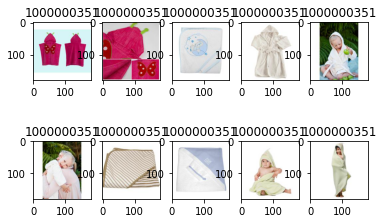

In [5]:
import matplotlib.pyplot as plt

for index, item in df.head(10).iterrows():
    plt.subplot(2, 5, index+1)
    plt.title(item[2])
    plt.imshow(item[1])

# IMPORTANT: For training small dataset you can skip this part of code
## Chunk reader higher level function
Below I've defined a function which you can call with another function as input, it will call the input function as many times with chunks of the dataset till the whole dataset is passed to it.
### Note: In the input function, you shouldn't store the passed chunks in a global variable, or your program will crash due to a memory congestion.
Remember, each image is a 180x180x3 3D np.array object, so the size of each record is ~97KB, therefore the size of the dataset when converted to np.array object equals ~24 GB which will not fit into your memory nor in the colab associated memory.

In [ ]:
def run_func_by_chunks(func, chunk_size=10 ** 4, num_runs=-1):
    chunk_num=0
    rets = ()
    with pd.read_csv("train_shuffled_100cat.csv", header=3, chunksize=chunk_size) as reader:
        for chunk in reader:
            
            chunk["image"] = chunk["image"].apply(
                lambda x: np.array(Image.open(io.BytesIO(base64.b64decode(x)))).reshape(180,180,3)
            )
            
            rets+=(func(np.array(chunk), chunk_num),)
            if num_runs==chunk_num+1:
                return rets
            chunk_num+=1
    return rets
    

In [ ]:
def log_chunks_and_sum_size(ch, ch_num):
    print("*", ch_num, ":", ch[0,1].shape)
    return ch.shape[0]
x = run_func_by_chunks(log_chunks_and_sum_size, chunk_size=1000, num_runs=-1)

AttributeError: ignored

## 1. Load your data

In [6]:
X_dev, Y_dev = np.stack(df["image"]), np.array(df["class"])

print(X_dev.shape,Y_dev.shape, Y_dev[-10:])

(2053, 180, 180, 3) (2053,) [9 9 9 9 9 9 9 9 9 9]


## 2. Explore your data 

Showing 10 samples from dev set

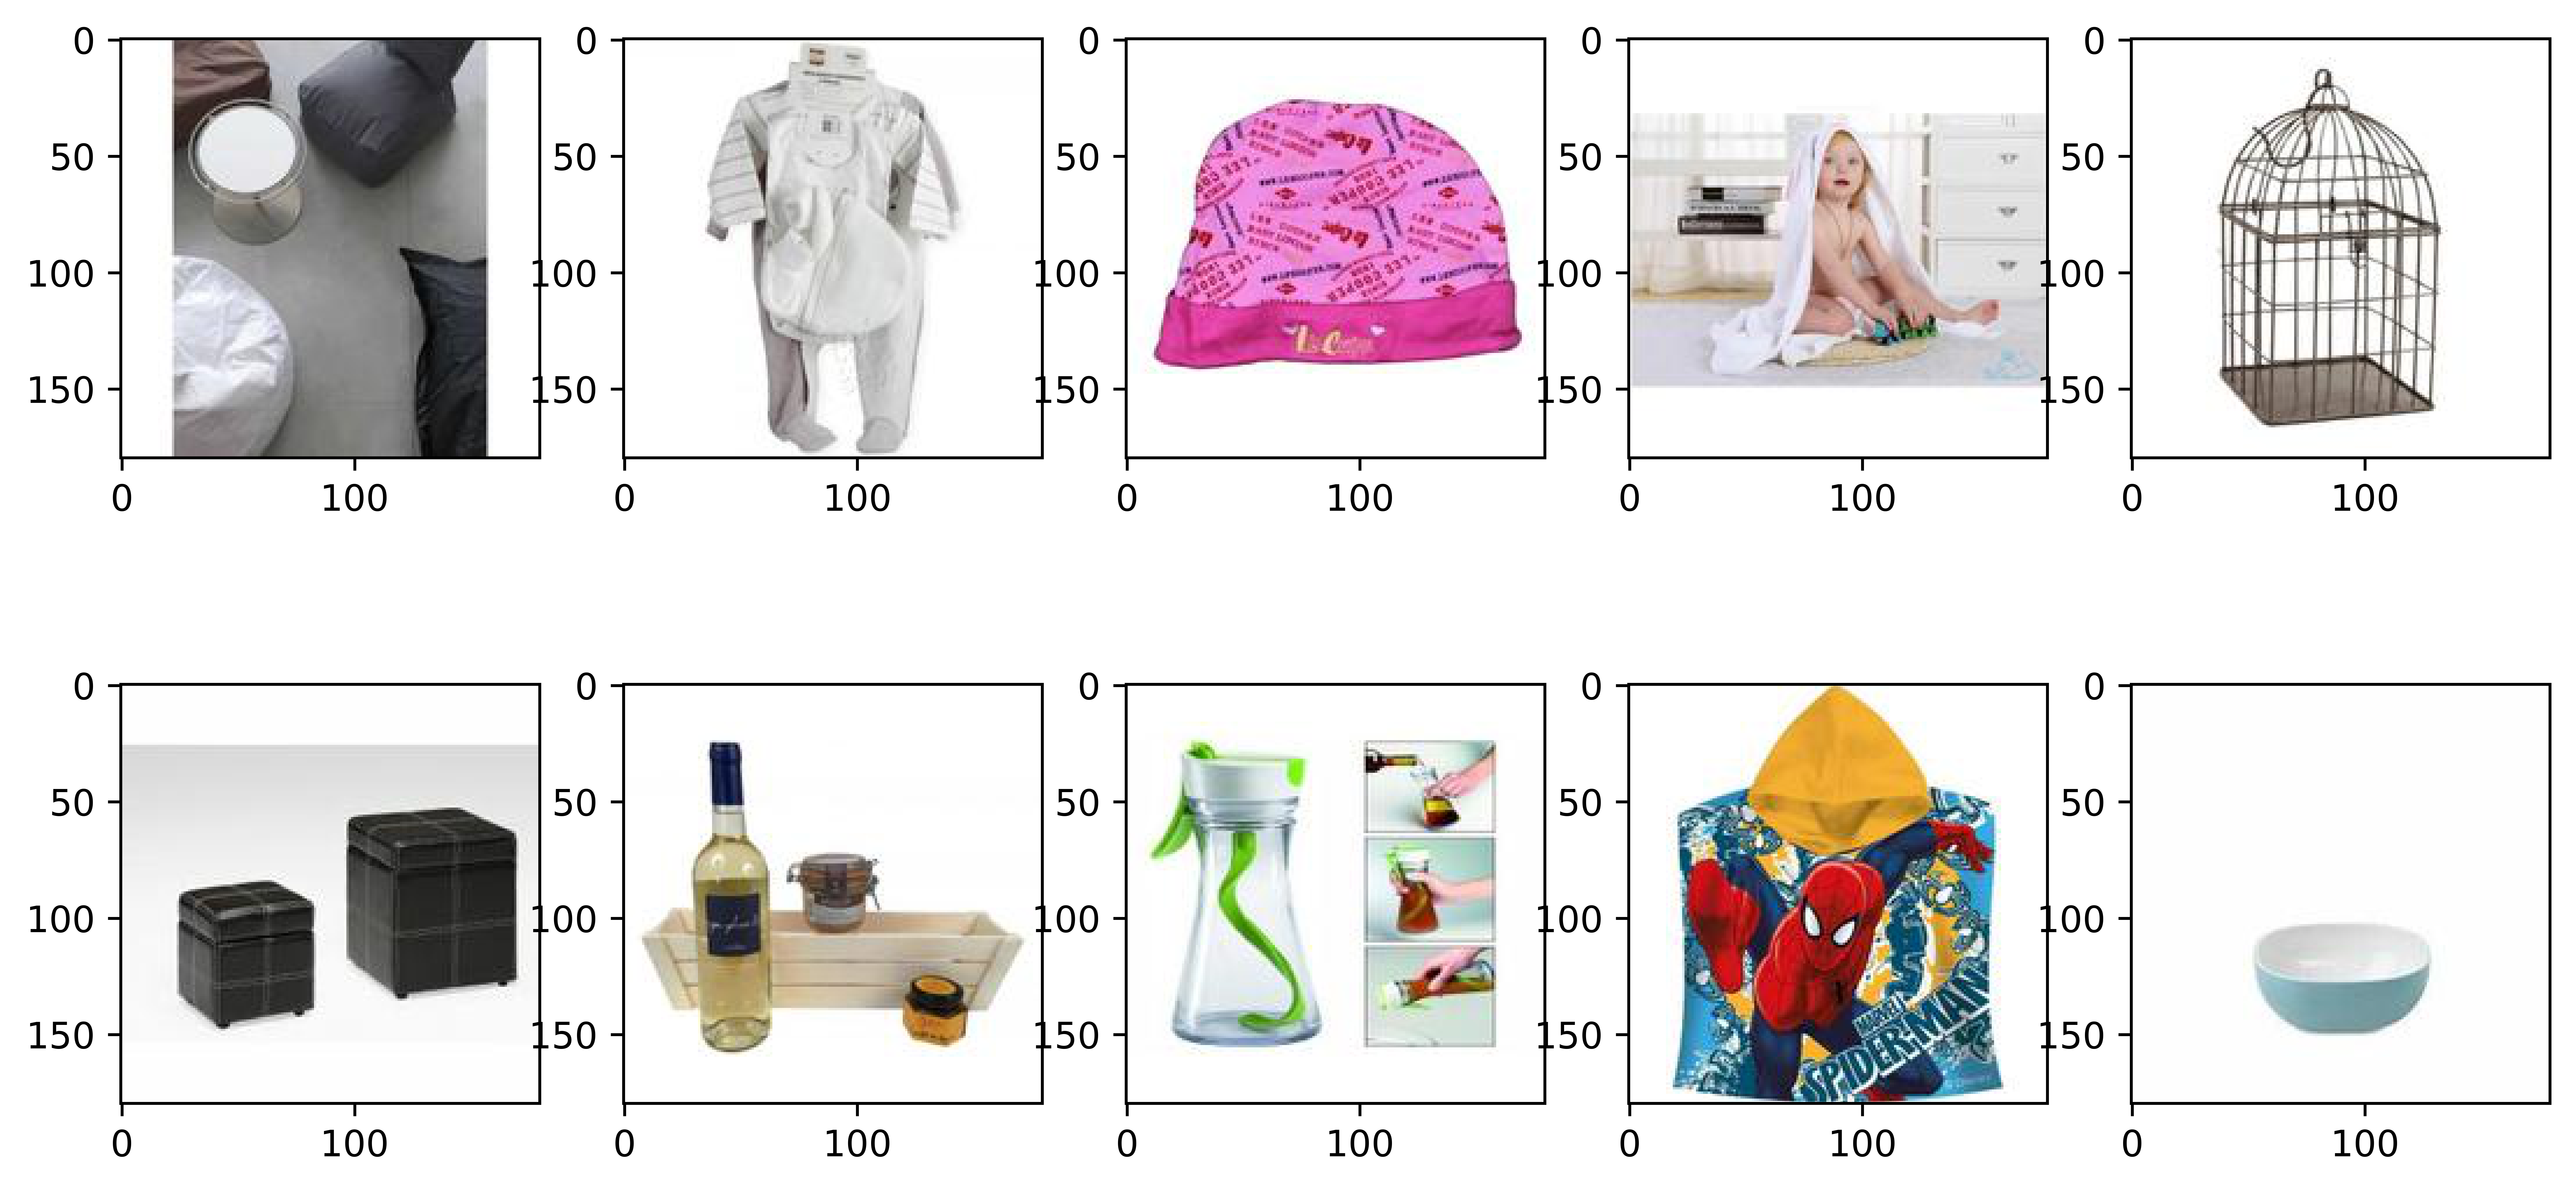

In [7]:
plt.figure(figsize=(12, 6), dpi=1000)
indexes = np.arange(len(X_dev))
np.random.shuffle(indexes)
for idx in range(10):
  plt.subplot(2, 5, idx + 1)
  plt.imshow(X_dev[indexes[idx]])
plt.show()

#Splitting dev set into train/val set

In [8]:
num_train = int(len(X_dev) * .7) #= splitting point of train/val set
num_val = int(len(X_dev) * .2)
num_test = len(X_dev) - num_train - num_val

X_train = X_dev[indexes[:num_train]]
Y_train = Y_dev[indexes[:num_train]]

X_val = X_dev[indexes[num_train:-num_test]]
Y_val = Y_dev[indexes[num_train:-num_test]]

X_test = X_dev[indexes[-num_test:]]
Y_test = Y_dev[indexes[-num_test:]]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (1437, 180, 180, 3)
X_val: (410, 180, 180, 3)
X_test: (206, 180, 180, 3)


## 3. Represent your labels using one hot encoding

In [9]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)


print("Y_train",  Y_train[:3])
print("Y_train_oh:",  Y_train_oh[:3])
print("Y_val",  Y_val[:3])
print("Y_val_oh:",  Y_val_oh[:3])
print("Y_test",  Y_test[:3])
print("Y_test_oh:",  Y_test_oh[:3])


#Scaling outputs
X_train_sc = X_train
X_val_sc = X_val
X_test_sc = X_test

print(X_train.shape)

Y_train [9 2 2]
Y_train_oh: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Y_val [5 0 8]
Y_val_oh: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Y_test [9 3 8]
Y_test_oh: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1437, 180, 180, 3)


## 4. Data scaling and Data augmentation

In [10]:
# Experiment with different data scaling methods

scaling_mode = 2  #= 0: disabled, 1: min-max normalization, 2: standardization

X_train = X_train_sc 
X_val = X_val_sc 
X_test = X_test_sc 

if scaling_mode == 1: 
  x_train_min = X_train.min()
  x_train_max = X_train.max()
  X_train = ( X_train - x_train_min ) / (x_train_max - x_train_min)
  x_val_min = X_val.min()
  x_val_max = X_val.max()
  X_val = ( X_val - x_val_min ) / (x_val_max - x_val_min)
  x_test_min = X_test.min()
  x_test_max = X_test.max()
  X_test = ( X_test - x_test_min ) / (x_test_max - x_test_min)
elif scaling_mode == 2:
  x_train_mean = X_train.mean()
  x_train_std = X_train.std()
#   print(x_train_mean, x_train_std)
  X_train = ( X_train - x_train_mean ) / x_train_std
  X_val = ( X_val - x_train_mean ) / x_train_std
  X_test = ( X_test - x_train_mean ) / x_train_std

In [11]:
# Create your data augmentation object to improve training
# set your batch size

batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":50,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.1, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'nearest',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

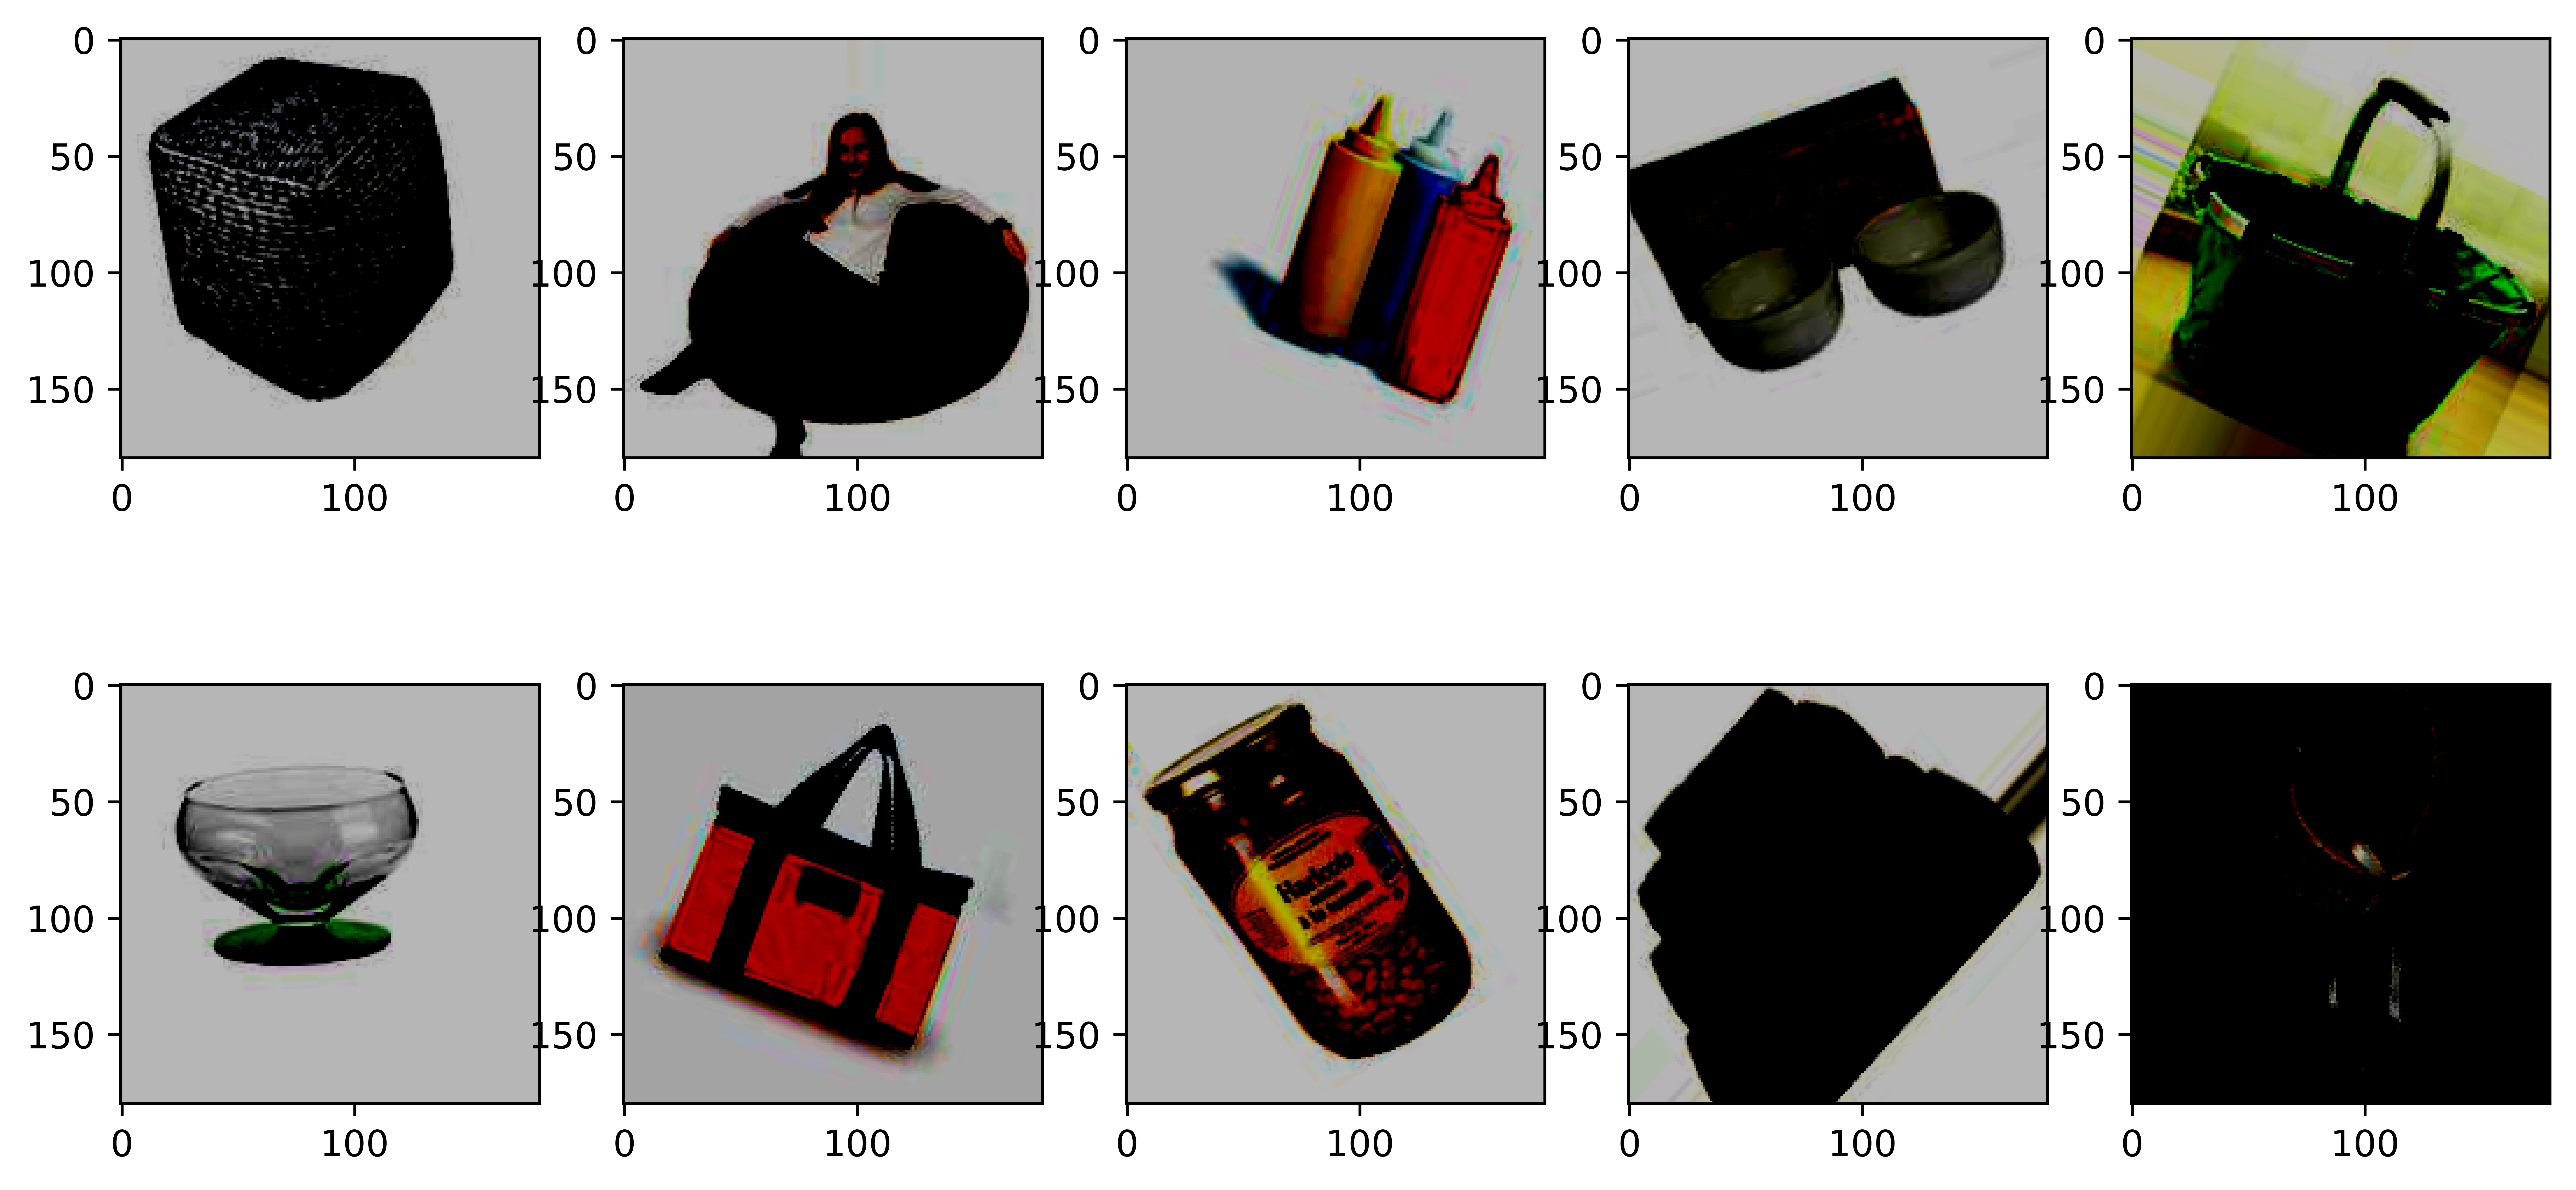

In [12]:
plt.figure(figsize=(12, 6), dpi=1000)
Xbatch,Ybatch = train_flow.__getitem__(1)
Xbatch_min = Xbatch.min(axis=1, keepdims=True)
Xbatch_max = Xbatch.max(axis=1, keepdims=True)

for ii in range(min(10, batch_size)):
    plt.subplot(2,5,ii+1)
    plt.imshow(Xbatch[ii].reshape(180, 180, 3), cmap=plt.get_cmap('gray'))
               
               
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [16]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.

model_name_cnn = "team_22_cdiscount_FCN.h5"
def my_model_cnn(ishape = (180,180,3), k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape= ishape)
    l1 = tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation= 'relu')(model_input)
    l2 = tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation= 'relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)

    l4 = tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation= 'relu')(l3)
    l5 = tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation= 'relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)


    l7 = tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation= 'relu')(l6)
    l8 = tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation= 'relu')(l7)
    l8_drop = tf.keras.layers.Dropout(0.25)(l8)
    l9 = tf.keras.layers.MaxPool2D((2,2))(l8_drop)


    flat = tf.keras.layers.Flatten()(l9)
    out = tf.keras.layers.Dense(k, activation= 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics= ["accuracy"])
    return model
model = my_model_cnn()
print(model.summary())      

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        9248

## 6. Define your callbacks (save your model, patience, etc.)

In [18]:
model_name_cnn = "team_22_cdiscount_FCN.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model


In [19]:
# train your model - decide for how many epochs
model.fit(train_flow,batch_size = 32, epochs = 200, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

45/45 [==============================] - 12s 276ms/step - loss: 1.6597 - accuracy: 0.4106 - val_loss: 1.9067 - val_accuracy: 0.3927
Epoch 87/200
45/45 [==============================] - ETA: 0s - loss: 1.6343 - accuracy: 0.4430

KeyboardInterrupt: ignored

## 8. Test your model

7/7 [==============================] - 1s 65ms/step - loss: 1.7975 - accuracy: 0.4369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

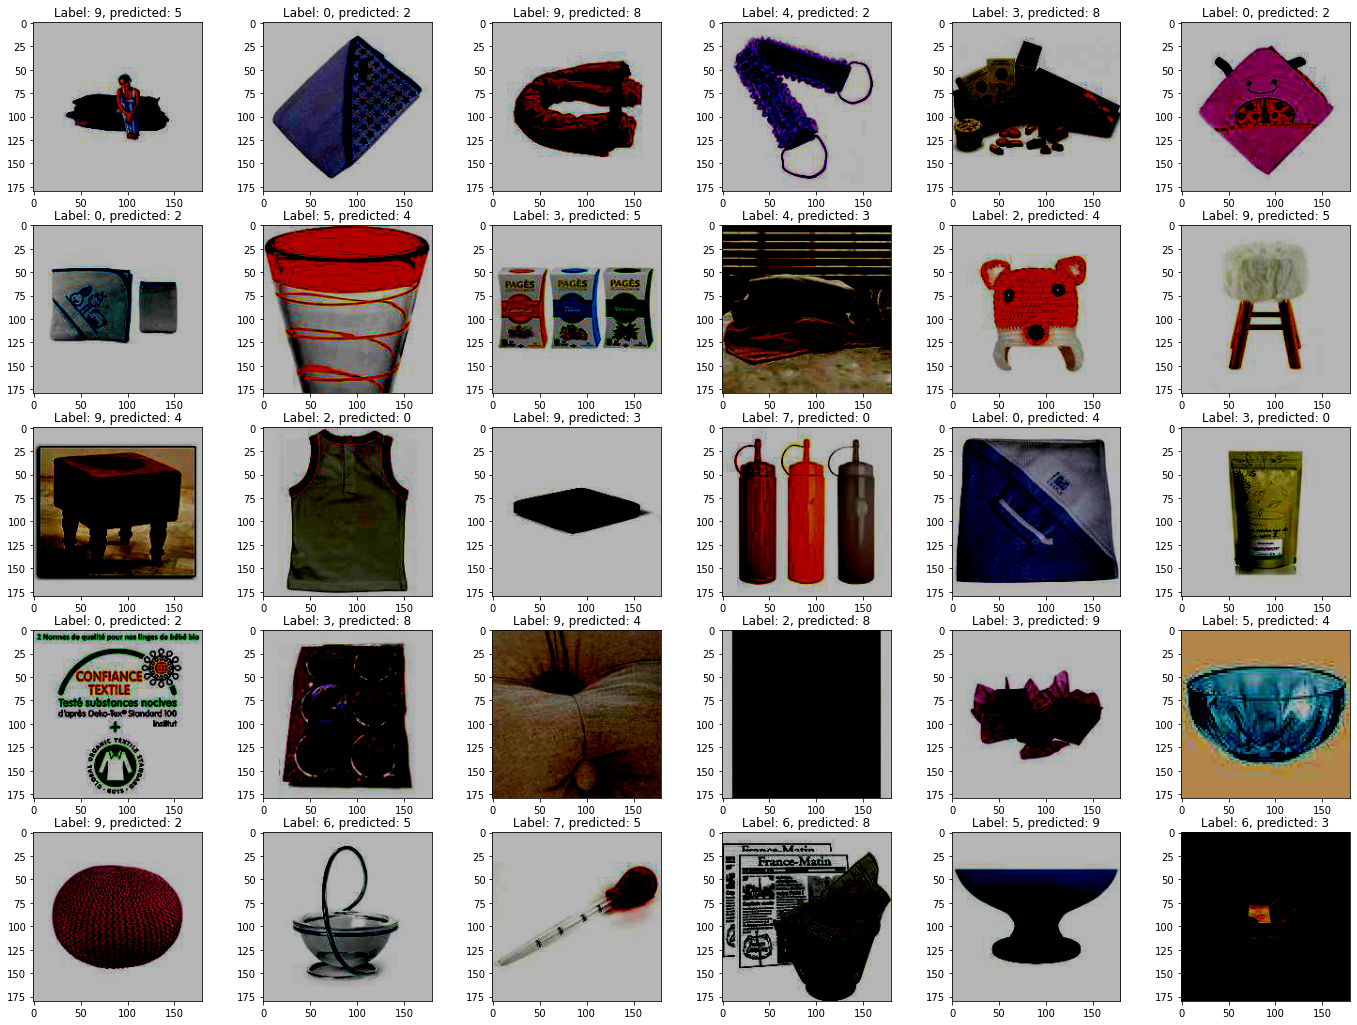

In [20]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...